In [6]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import numpy as np
import random
import os
from dotenv import load_dotenv


In [7]:
load_dotenv()
os.environ.get('TRAINING_DIRECTORY')


'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light'

In [8]:
# Set the path to the folders containing the images
# train_dir = './training_data/'
train_dir = os.environ.get('TRAINING_DIRECTORY')

# Define the image size
img_height = 1024
img_width = 1024

# Define the batch size
batch_size = 32


In [9]:
# Create a training dataset from the images in the training folder
(train_ds, validation_ds) = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 300 files belonging to 2 classes.
Using 240 files for training.
Using 60 files for validation.


['mini-healthy', 'mini-infected']


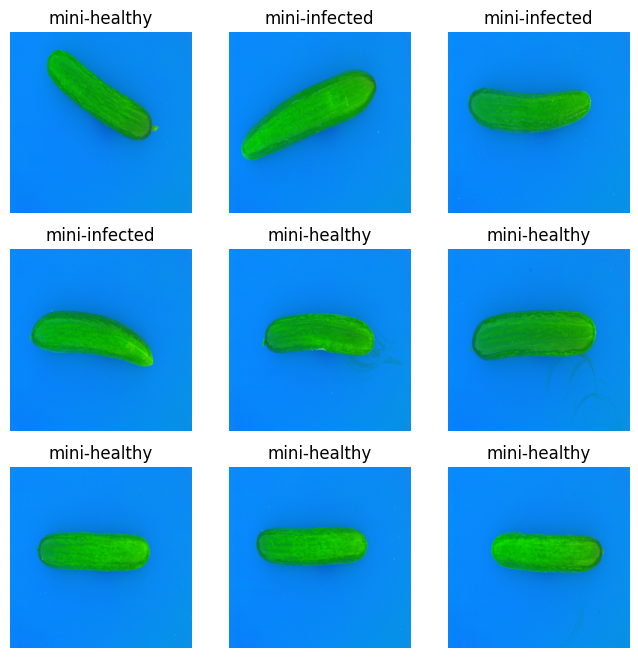

In [10]:
classes = train_ds.class_names
print(classes)

# Plot some images with their labels
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classes[labels[i]])
        plt.axis('off')


In [11]:
(img_batch, label_batch) = (train_ds.as_numpy_iterator().next())


In [12]:
img_batch = img_batch.astype('uint8')
print(img_batch[0].shape)
print(label_batch.shape)
print(img_batch[0])
image = img_batch[0]


(1024, 1024, 3)
(32,)
[[[ 11 134 254]
  [ 11 134 254]
  [  7 130 251]
  ...
  [ 16 134 235]
  [ 24 131 246]
  [ 20 133 246]]

 [[  8 131 250]
  [  8 131 250]
  [  4 131 245]
  ...
  [ 18 131 227]
  [ 36 142 236]
  [ 29 137 246]]

 [[  7 134 252]
  [  8 130 250]
  [  5 140 246]
  ...
  [ 20 136 239]
  [ 22 133 250]
  [ 14 140 241]]

 ...

 [[  5 133 248]
  [  8 128 246]
  [  9 129 254]
  ...
  [ 18 140 224]
  [ 13 142 236]
  [ 10 142 228]]

 [[  3 142 249]
  [  9 139 251]
  [ 12 132 248]
  ...
  [ 11 142 224]
  [  7 144 226]
  [  6 143 223]]

 [[  9 133 251]
  [  9 123 248]
  [ 11 126 252]
  ...
  [ 12 142 225]
  [ 17 138 226]
  [ 16 136 229]]]


(array([8.54380e+04, 8.92700e+03, 4.73700e+03, 3.58100e+03, 2.91700e+03,
        2.57200e+03, 2.11900e+03, 1.90800e+03, 1.67900e+03, 1.58800e+03,
        1.76400e+03, 1.42200e+03, 1.25100e+03, 1.17000e+03, 1.07700e+03,
        9.35000e+02, 8.64000e+02, 7.99000e+02, 7.29000e+02, 7.24000e+02,
        8.38000e+02, 7.12000e+02, 6.20000e+02, 5.36000e+02, 4.85000e+02,
        3.93000e+02, 3.15000e+02, 2.94000e+02, 2.23000e+02, 2.09000e+02,
        2.10000e+02, 1.64000e+02, 1.62000e+02, 2.17000e+02, 1.77000e+02,
        1.93000e+02, 2.76000e+02, 4.88000e+02, 1.21500e+03, 2.73900e+03,
        6.73300e+03, 9.20400e+03, 1.25010e+04, 1.74580e+04, 2.95720e+04,
        6.26160e+04, 1.25213e+05, 1.73186e+05, 2.13275e+05, 2.62151e+05]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3

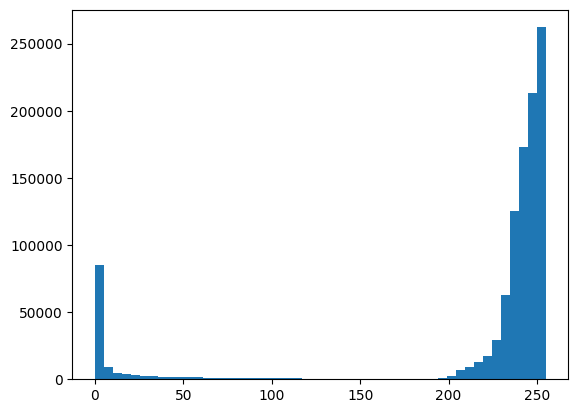

In [20]:
plt.hist(image[:,:,2].ravel(), bins=50)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


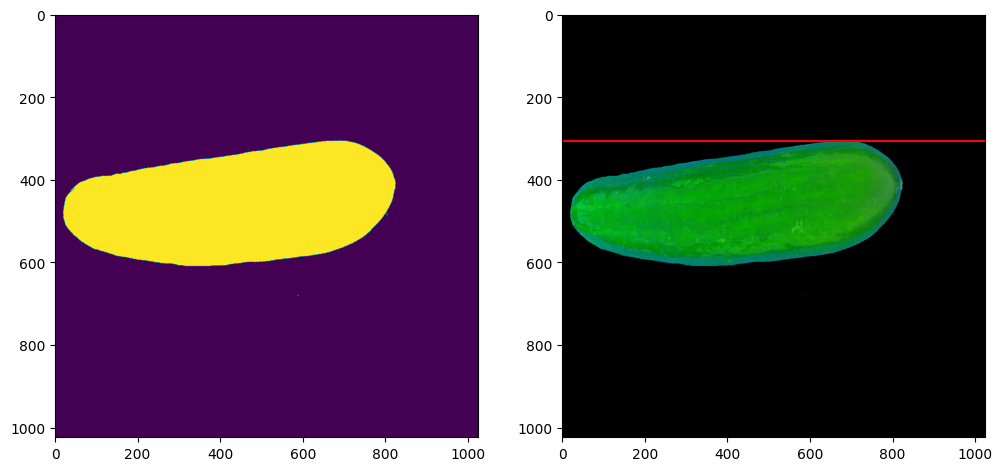

In [20]:
# Get mask for only pixels where B(lue) value is < XXX 
image = img_batch[random.randint(0, img_batch.shape[0] - 1)]
masked_img = (image[..., 2] < 150)

# Get the first y-pixel value where at least 1/64 of the pixels are masked
first_cucumber_pixel_y = None
threshold = img_width / 64
for i in range(masked_img.shape[0]):
    if np.sum(masked_img[i, :]) > threshold:
        first_cucumber_pixel_y = i
        break

img_mask_reshaped = np.zeros((*masked_img.shape, 3))
img_mask_reshaped[np.where(masked_img)] = [1, 1, 1]

(ret, masked_img) = cv.threshold(image[..., 2], 150, 255, cv.THRESH_BINARY_INV)
print(masked_img)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(masked_img)
plt.subplot(1, 2, 2)
plt.axhline(y=first_cucumber_pixel_y, color='r', linestyle='-')
plt.imshow(np.multiply(image, img_mask_reshaped).astype(np.uint))
plt.show()
